In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import os

zip_path = 'alzheimers_dataset.zip'
extract_path = '/content/alzheimers_dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
IMAGE_HEIGHT = 208
IMAGE_WIDTH = 176
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "alzheimers_dataset/alzheimers_dataset",
    shuffle = True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 6281 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 208, 176, 3)
[2 3 3 2 3 2 2 3 2 2 3 2 2 2 3 2 2 3 0 2 2 2 3 3 2 0 0 2 3 2 2 0]


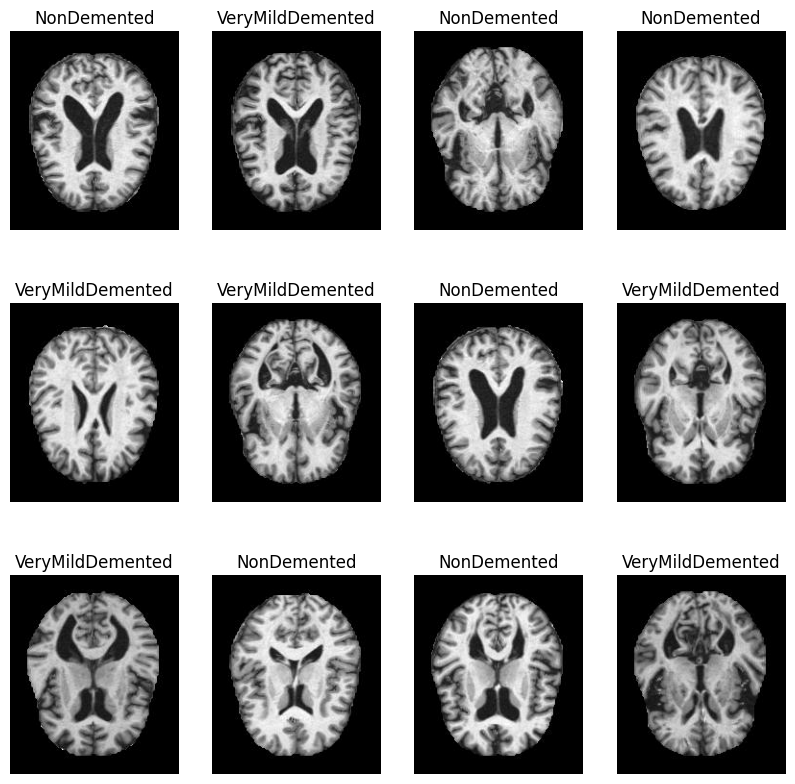

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

197

In [ ]:
train_size = 0.8
len(dataset) * train_size

157.60000000000002

In [ ]:
train_ds = dataset.take(157)
len(train_ds)

157

In [ ]:
test_ds = dataset.skip(157)
len(test_ds)

40

In [ ]:
val_size = 0.1
len(dataset) * val_size

19.700000000000003

In [ ]:
val_ds = test_ds.take(19)
len(val_ds)

19

In [ ]:
test_ds = test_ds.skip(19)
len(test_ds)

21

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

157

In [ ]:
len(val_ds)

19

In [ ]:
len(test_ds)

21

#CNN

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  tf.keras.layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 208, 176, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 206, 174, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 103, 87, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 101, 85, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 50, 42, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 48, 40, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 24, 20, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 22, 18, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 11, 9, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 9, 7, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 4, 3, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 2, 1, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,620 (686.02 KB)

 Trainable params: 175,620 (686.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.4966 - loss: 1.0529 - val_accuracy: 0.4737 - val_loss: 1.0861
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.5322 - loss: 0.9848 - val_accuracy: 0.5658 - val_loss: 0.8862
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.6055 - loss: 0.8724 - val_accuracy: 0.6332 - val_loss: 0.8161
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.6076 - loss: 0.8165 - val_accuracy: 0.6908 - val_loss: 0.6971
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.7079 - loss: 0.6660 - val_accuracy: 0.7747 - val_loss: 0.4995
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7847 - loss: 0.5058 - val_accuracy: 0.8766 - val_loss: 0.3324
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.8708 - loss: 0.3234 - val_accuracy: 0.9408 - val_loss: 0.1739
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.9357 - loss: 0.1785 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 922ms/step - accuracy: 0.9913 - loss: 0.0257


In [ ]:
scores

[0.017537293955683708, 0.9953774809837341]

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 157}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.5022995471954346,
 0.5536892414093018,
 0.6046790480613708,
 0.6258748173713684,
 0.7126574516296387,
 0.8008398413658142,
 0.8780243992805481,
 0.933813214302063,
 0.956008791923523,
 0.9728054404258728,
 0.9788042306900024,
 0.9784043431282043,
 0.9798040390014648,
 0.9948010444641113,
 0.9890022277832031,
 0.9874024987220764,
 0.984403133392334,
 0.9848030209541321,
 0.9906018972396851,
 0.9974005222320557,
 0.9854029417037964,
 0.9848030209541321,
 0.9892021417617798,
 0.9950010180473328,
 0.985602855682373,
 0.9932013750076294,
 0.9970005750656128,
 0.9972005486488342,
 0.9822035431861877,
 0.9916017055511475,
 0.9886022806167603,
 0.9944010972976685,
 0.999200165271759,
 0.9874024987220764,
 0.9952009320259094,
 0.9980003833770752,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

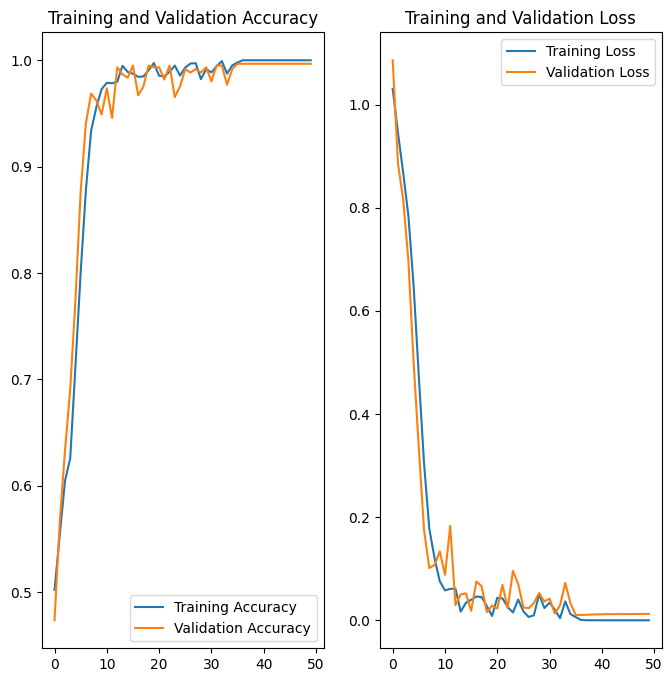

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: VeryMildDemented
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
predicted label: VeryMildDemented


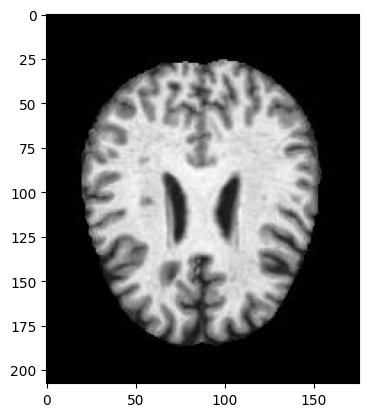

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


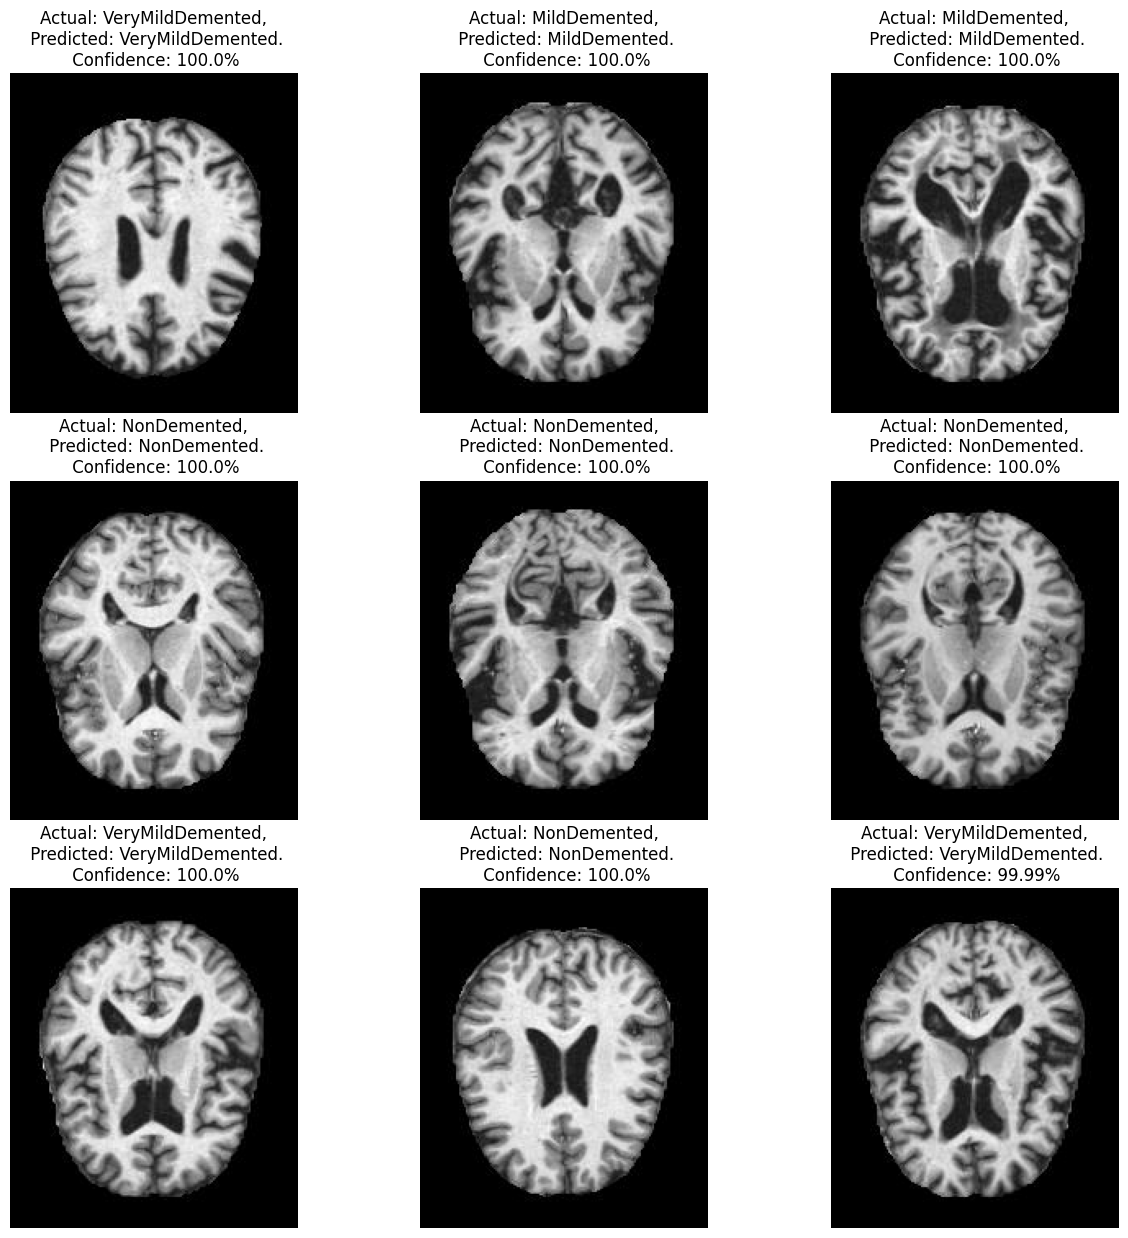

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
model.save('/content/model.h5')

#RNN

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64  # Example smaller size, adjust as needed
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = 4
BATCH_SIZE = 32  # Decreasing batch size to reduce memory usage

In [ ]:
model = models.Sequential([
    # Resizing and Rescaling
    layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.Rescaling(1./255),

    # CNN Layers
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flattening the image
    layers.Flatten(),

    # LSTM/GRU layers
    layers.Reshape((-1, 64)),  # Reshaping for RNN (sequence length, features)
    layers.GRU(64, return_sequences=True),  # Using GRU instead of LSTM
    layers.GRU(32),

    # Dense layers
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.build(input_shape=(None, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 196, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 196, 64)             │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,132 (219.27 KB)

 Trainable params: 56,132 (219.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 404ms/step - accuracy: 0.5060 - loss: 1.0840 - val_accuracy: 0.4967 - val_loss: 0.9979
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.5055 - loss: 1.0407 - val_accuracy: 0.5128 - val_loss: 1.0160
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.5012 - loss: 1.0196 - val_accuracy: 0.4951 - val_loss: 0.9997
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 388ms/step - accuracy: 0.5129 - loss: 1.0242 - val_accuracy: 0.5132 - val_loss: 0.9909
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 389ms/step - accuracy: 0.5058 - loss: 1.0245 - val_accuracy: 0.5164 - val_loss: 1.0165
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.5097 - loss: 1.0144 - val_accuracy: 0.5049 - val_loss: 1.0098
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.5214 - loss: 1.0003 - val_accuracy: 0.5148 - val_loss: 0.9935
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 403ms/step - accuracy: 0.5109 - loss: 1

In [ ]:
scores = model.evaluate(test_ds)
print(f'Test Loss: {scores[0]}, Test Accuracy: {scores[1]}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9724 - loss: 0.0766
Test Loss: 0.08306806534528732, Test Accuracy: 0.9672619104385376


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

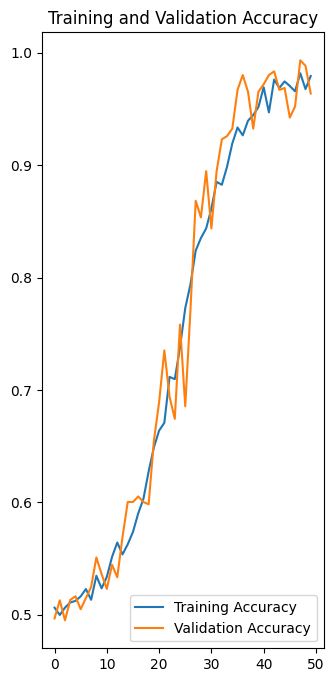

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

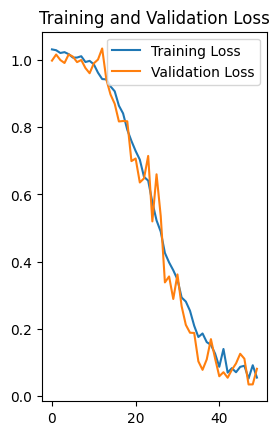

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Autoencoder

In [ ]:
encoder = models.Sequential([
    # Removed Flatten layer
    layers.Dense(128, activation='relu', input_shape=(208, 176, 3)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu')
])

In [ ]:
decoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=[32]),
    layers.Dense(128, activation='relu'),
    layers.Dense(IMAGE_HEIGHT * IMAGE_WIDTH * CHANNELS, activation='sigmoid'),
    layers.Reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
autoencoder = models.Sequential([encoder, decoder])

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-42-eb0fce82c0f6>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 70, in train_step

Incompatible shapes: [32] vs. [32,64,64,3]
	 [[{{node gradient_tape/compile_loss/mse/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_122661]